In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
import requests
import math
from fa2 import ForceAtlas2

In [2]:
url = 'https://raw.githubusercontent.com/d2ski/football-transfers-data/main/dataset/transfers.csv'
df = pd.read_csv(url, index_col=0)
df.head()

,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,player_nation,...,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
league,,,,,,,,,,,,,,,,,,,,,
GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23.0,Ecuador,...,1071,Wigan Athletic,England,18800000.0,NaN,False,False,False,False,310832
GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,Senegal,...,687,Molde FK,Norway,4500000.0,1600000.0,False,False,False,False,319841
GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20.0,France,...,40,FC Girondins Bordeaux,France,4000000.0,400000.0,False,False,False,False,315185
GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,England,...,762,Newcastle United,England,0.0,NaN,True,False,False,False,306421
GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,England,...,5242,Manchester United U18,England,NaN,NaN,False,False,False,False,339015


In [3]:
url='https://gist.githubusercontent.com/fogonwater/bc2b98baeb2aa16b5e6fbc1cf3d7d545/raw/6fd2951260d8f171181a45d2f09ee8b2c7767330/countries.csv'
df_continents = pd.read_csv(url, index_col=0)
df_continents=df_continents[['country_name','country_name_full','continent_name']]
url='https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-continent.json'
df_continents = pd.read_json(url)
df_continents.loc[63,'continent']='England'
new_rows = pd.DataFrame({'country': ['Without Club','Russia','Retired','Unknown','Ban','Bosnia-Herzegovina','Jersey','Kosovo','Career break',"Cote d'Ivoire", 'The Gambia', 'DR Congo', 'Libya', 'Réunion','Hongkong','Korea, North', 'Palästina','Brunei Darussalam', 'Chinese Taipei (Taiwan)', 'Korea, South','Neukaledonien','Tahiti','Curacao' ,'St. Lucia'],
                         
                         
                    'continent': ['No Club','Europe','Retired','Unknown','Ban','Europe','Europe','Europe','Retired','Africa','Africa','Africa','Africa','Africa','Asia','Asia','Asia','Asia','Asia','Asia','Oceania','Oceania','South America','North America']})
df_continents = df_continents.append(new_rows, ignore_index=True)
df=df.merge(df_continents,left_on='counter_team_country',right_on='country',how='left')
df=df.merge(df_continents,left_on='player_nation',right_on='country',how='left',suffixes=('_team','_player'))
df['continent_player'] = df['continent_player'].fillna('Unknown')
del df['country_team']
del df['country_player']

In [4]:
df

,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,player_nation,...,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id,continent_team,continent_player
0,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23.0,Ecuador,...,England,18800000.0,NaN,False,False,False,False,310832,England,South America
1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,Senegal,...,Norway,4500000.0,1600000.0,False,False,False,False,319841,Europe,Africa
2,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20.0,France,...,France,4000000.0,400000.0,False,False,False,False,315185,Europe,Europe
3,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,England,...,England,0.0,NaN,True,False,False,False,306421,England,England
4,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,England,...,England,NaN,NaN,False,False,False,False,339015,England,England
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70001,2021,w,306,SC Heerenveen,Netherlands,in,257808,Runar Espejord,25.0,Norway,...,Norway,NaN,500000.0,False,True,True,False,3071862,Europe,Europe
70002,2021,w,306,SC Heerenveen,Netherlands,in,580142,Joaquín Fernández,22.0,Uruguay,...,Uruguay,NaN,100000.0,False,True,True,False,3268245,South America,South America
70003,2021,w,468,Sparta Rotterdam,Netherlands,in,340353,Maduka Okoye,22.0,Nigeria,...,England,NaN,1000000.0,False,True,False,False,3619917,England,Africa
70004,2021,w,468,Sparta Rotterdam,Netherlands,left,340353,Maduka Okoye,22.0,Nigeria,...,England,7000000.0,1000000.0,False,False,False,False,3619916,England,Africa


In [5]:
G = nx.MultiDiGraph()
for index, row in df.iterrows():
    if row['team_country'] == 'England' or row['counter_team_country'] == 'England':
        if row['team_name'] not in G.nodes():
            G.add_node(row['team_name'], league=row['team_country'],continent='England')
        if row['counter_team_name'] not in G.nodes():
            G.add_node(row['counter_team_name'], league=row['counter_team_country'],continent=row['continent_team'])
for index, row in df.iterrows():
    if row['team_country'] == 'England' or row['counter_team_country'] == 'England':
        if math.isnan(row['transfer_fee_amnt']):
            tmpfee = 0
        else:
            tmpfee = row['transfer_fee_amnt']
        if row['dir'] == 'in':
            G.add_edge(row['counter_team_name'],row['team_name'], player = row['player_name'], fee = tmpfee,nationality=row['player_nation'],continent_player=row['continent_player'])
        else:
            G.add_edge(row['team_name'],row['counter_team_name'], player = row['player_name'], fee = tmpfee,nationality=row['player_nation'],continent_player=row['continent_player'])

In [6]:
tmpset = set(nx.get_node_attributes(G, 'league').values())

In [7]:
inthash = dict()
counter = 1
for i in tmpset:
    inthash[i] = counter
    counter+=1

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 27.93it/s]


BarnesHut Approximation  took  5.87  seconds
Repulsion forces  took  63.50  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.78  seconds


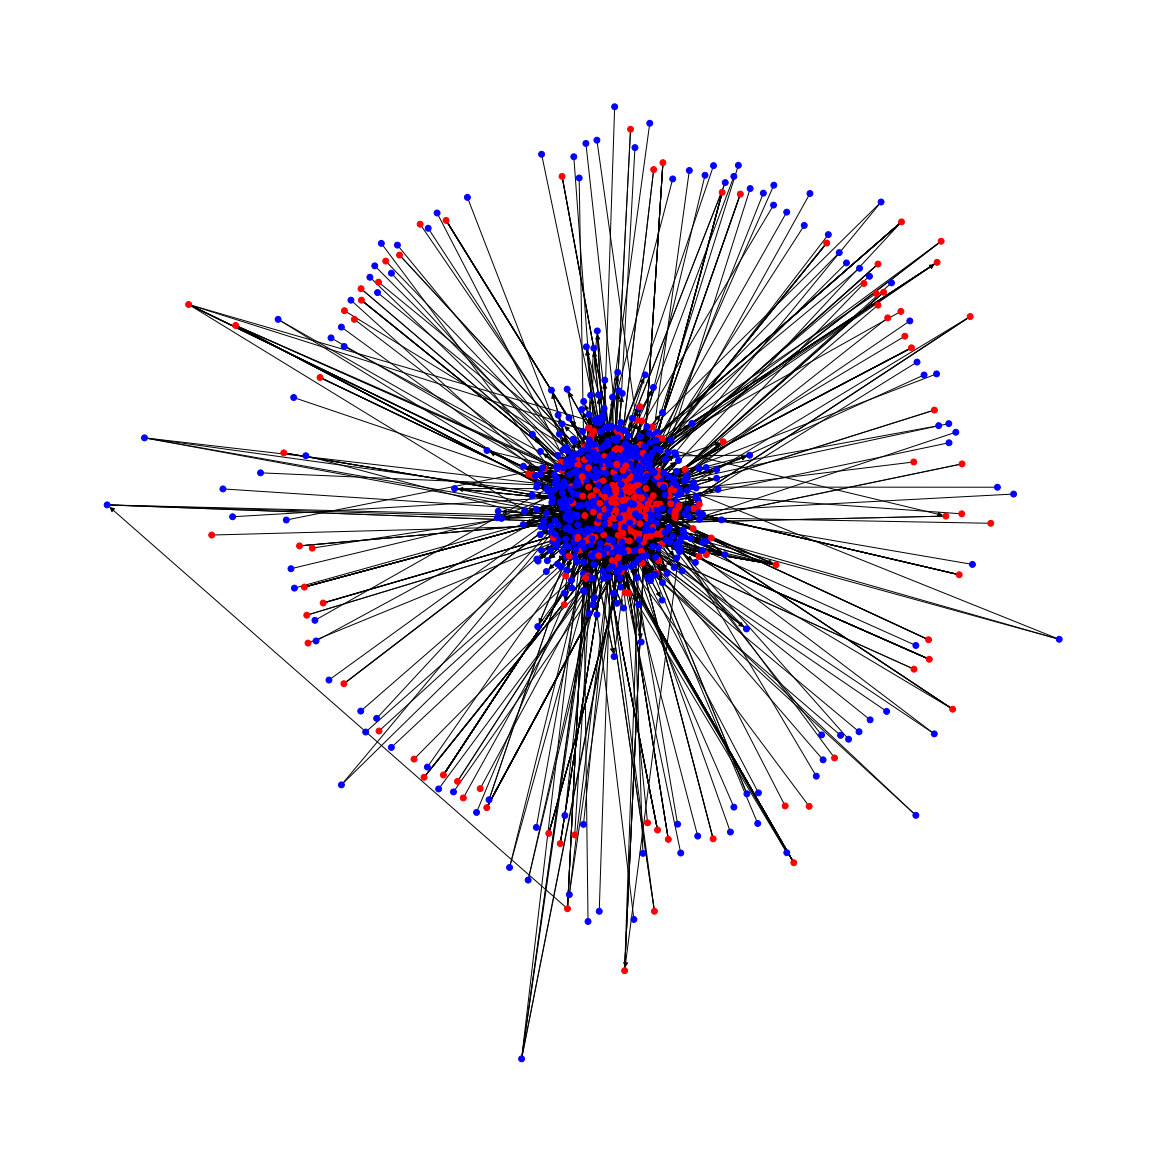

In [8]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=0.1,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
#colors = [inthash[nx.get_node_attributes(G, 'league')[i]]/len(tmpset) for i in G.nodes()]
colors = ['red' if nx.get_node_attributes(G, 'league')[i] == 'England' else 'blue' for i in G.nodes()]
plt.figure(figsize=(16,16)) 
#plt.axis([-1500, 1500, -1500, 1500])
nx.draw(G, pos=positions, node_color=colors, edge_color='black', arrows=True, arrowsize=10, node_size=35)
#txt="Our graph plotted with forceatlas, colours being worlds red=marvel, blue=dc and nodesize being based on node degree"
#plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [24]:
set(df['continent_team'])

{'Africa',
 'Asia',
 'Ban',
 'England',
 'Europe',
 'No Club',
 'North America',
 'Oceania',
 'Retired',
 'South America',
 'Unknown'}

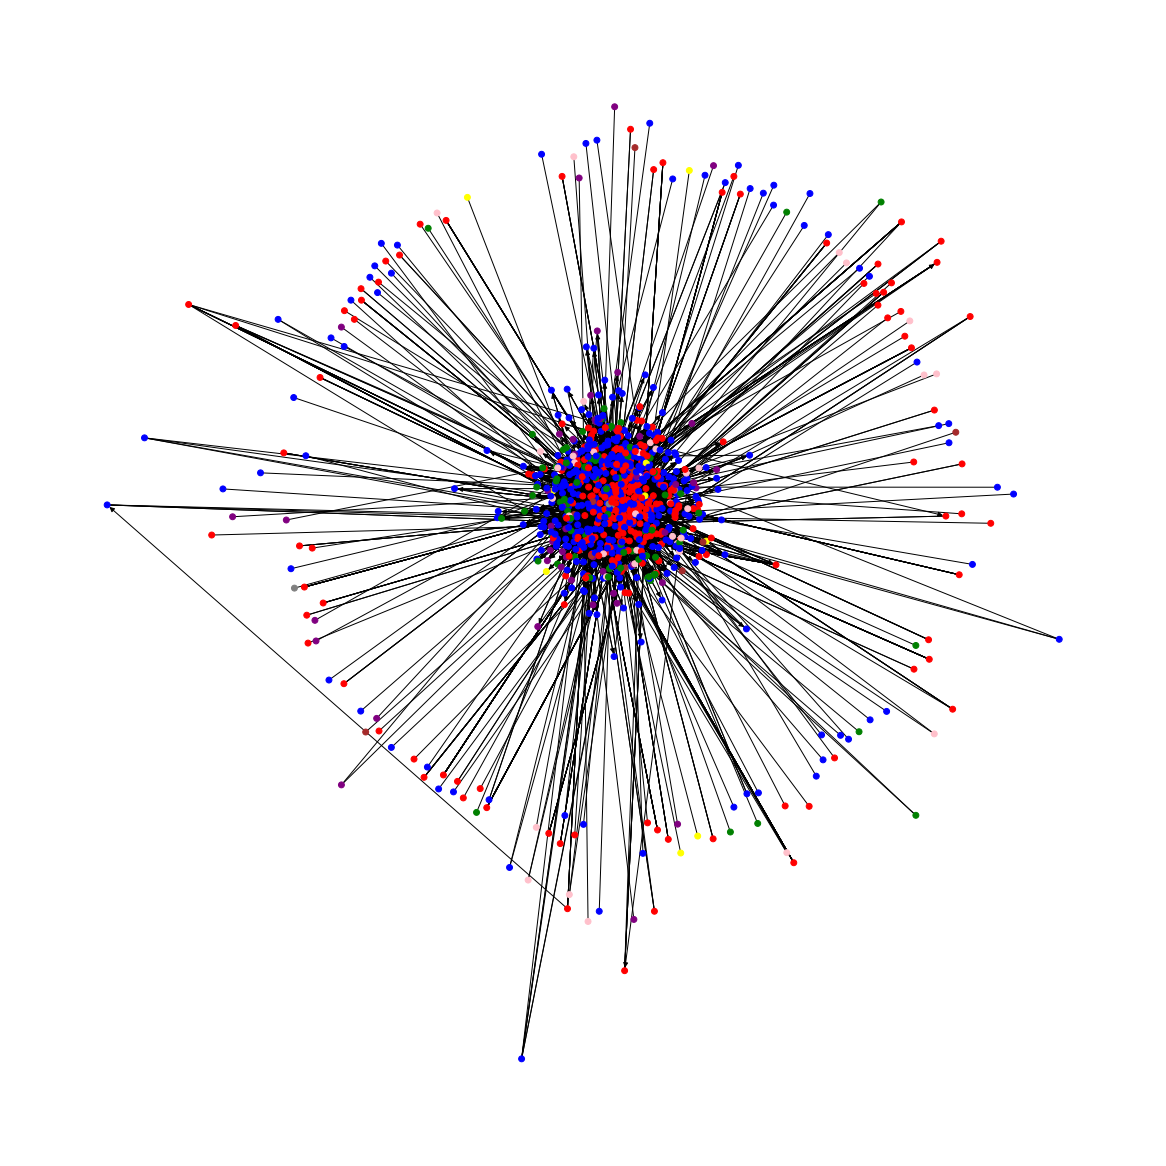

In [25]:
color_map = nx.get_node_attributes(G,'continent')
for key in color_map:
    if color_map[key] == 'England':
        color_map[key] = 'red'
    elif color_map[key] == 'Europe':
        color_map[key] = 'blue'
    elif color_map[key] == 'Africa':
        color_map[key] = 'yellow'
    elif color_map[key] == 'Asia':
        color_map[key] = 'green'
    elif color_map[key] == 'North America':
        color_map[key] = 'pink'
    elif color_map[key] == 'Oceania':
        color_map[key] = 'brown'
    elif color_map[key] == 'South America':
        color_map[key] = 'purple'
    else:
        color_map[key] = 'gray'
contcolor = [color_map.get(node) for node in G.nodes()]
plt.figure(figsize=(16,16)) 
nx.draw(G, pos=positions, node_color=contcolor, edge_color='black', arrows=True, arrowsize=10, node_size=35)

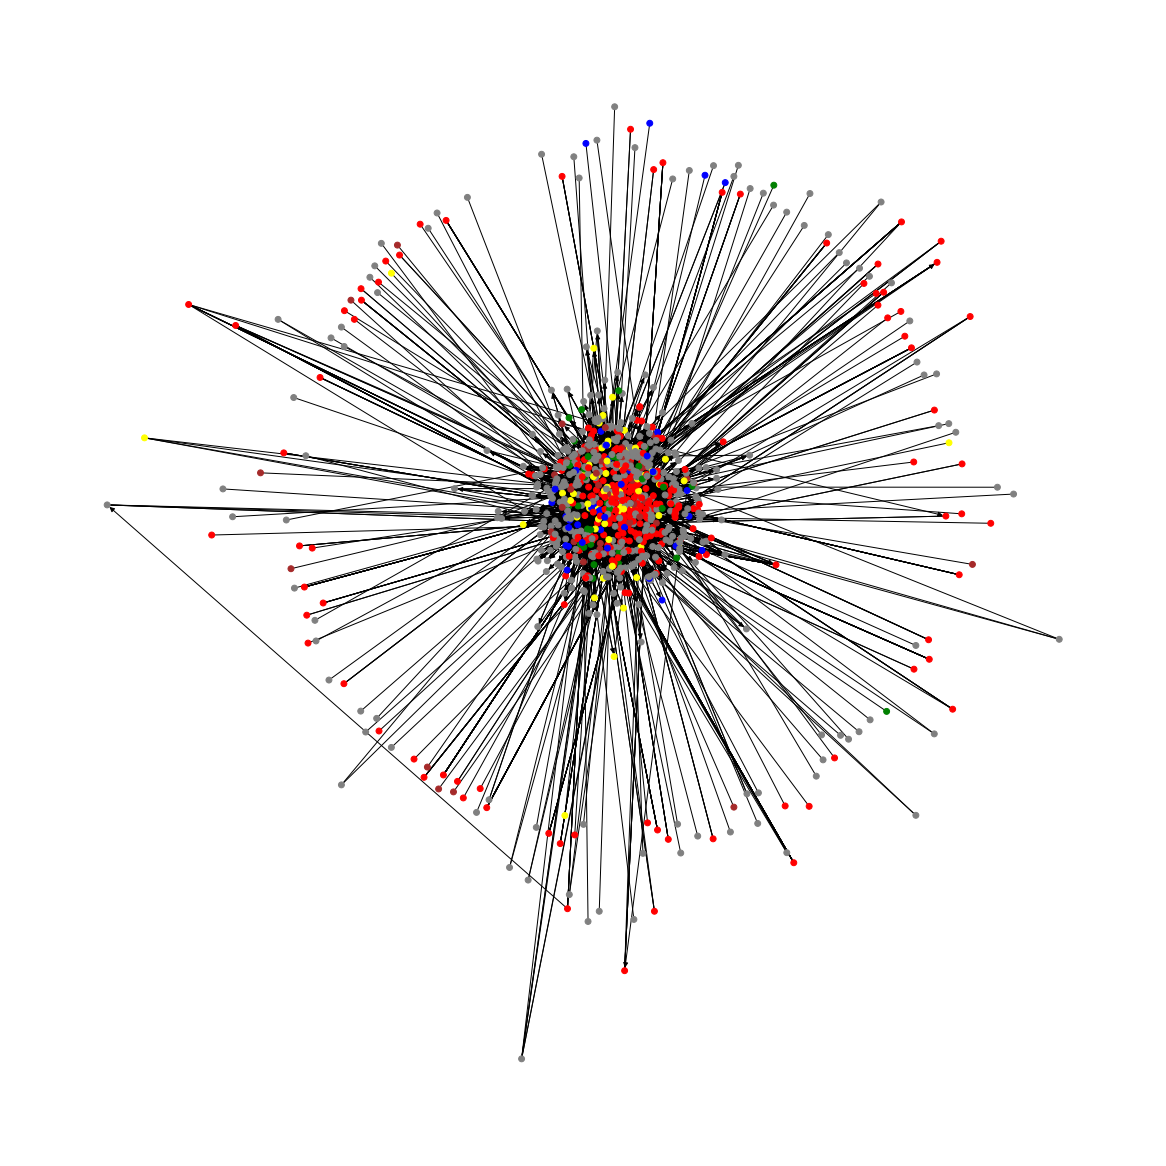

In [26]:
colors = ['red' if nx.get_node_attributes(G, 'league')[i] == 'England' else 'yellow' if nx.get_node_attributes(G, 'league')[i] == 'Spain'
          else 'blue' if nx.get_node_attributes(G, 'league')[i] == 'Italy' else 'green' if nx.get_node_attributes(G, 'league')[i] == 'Germany' 
          else 'brown' if nx.get_node_attributes(G, 'league')[i] == 'France' else 'gray' for i in G.nodes()]
plt.figure(figsize=(16,16)) 
#plt.axis([-1500, 1500, -1500, 1500])
nx.draw(G, pos=positions, node_color=colors, edge_color='black', arrows=True, arrowsize=10, node_size=35)

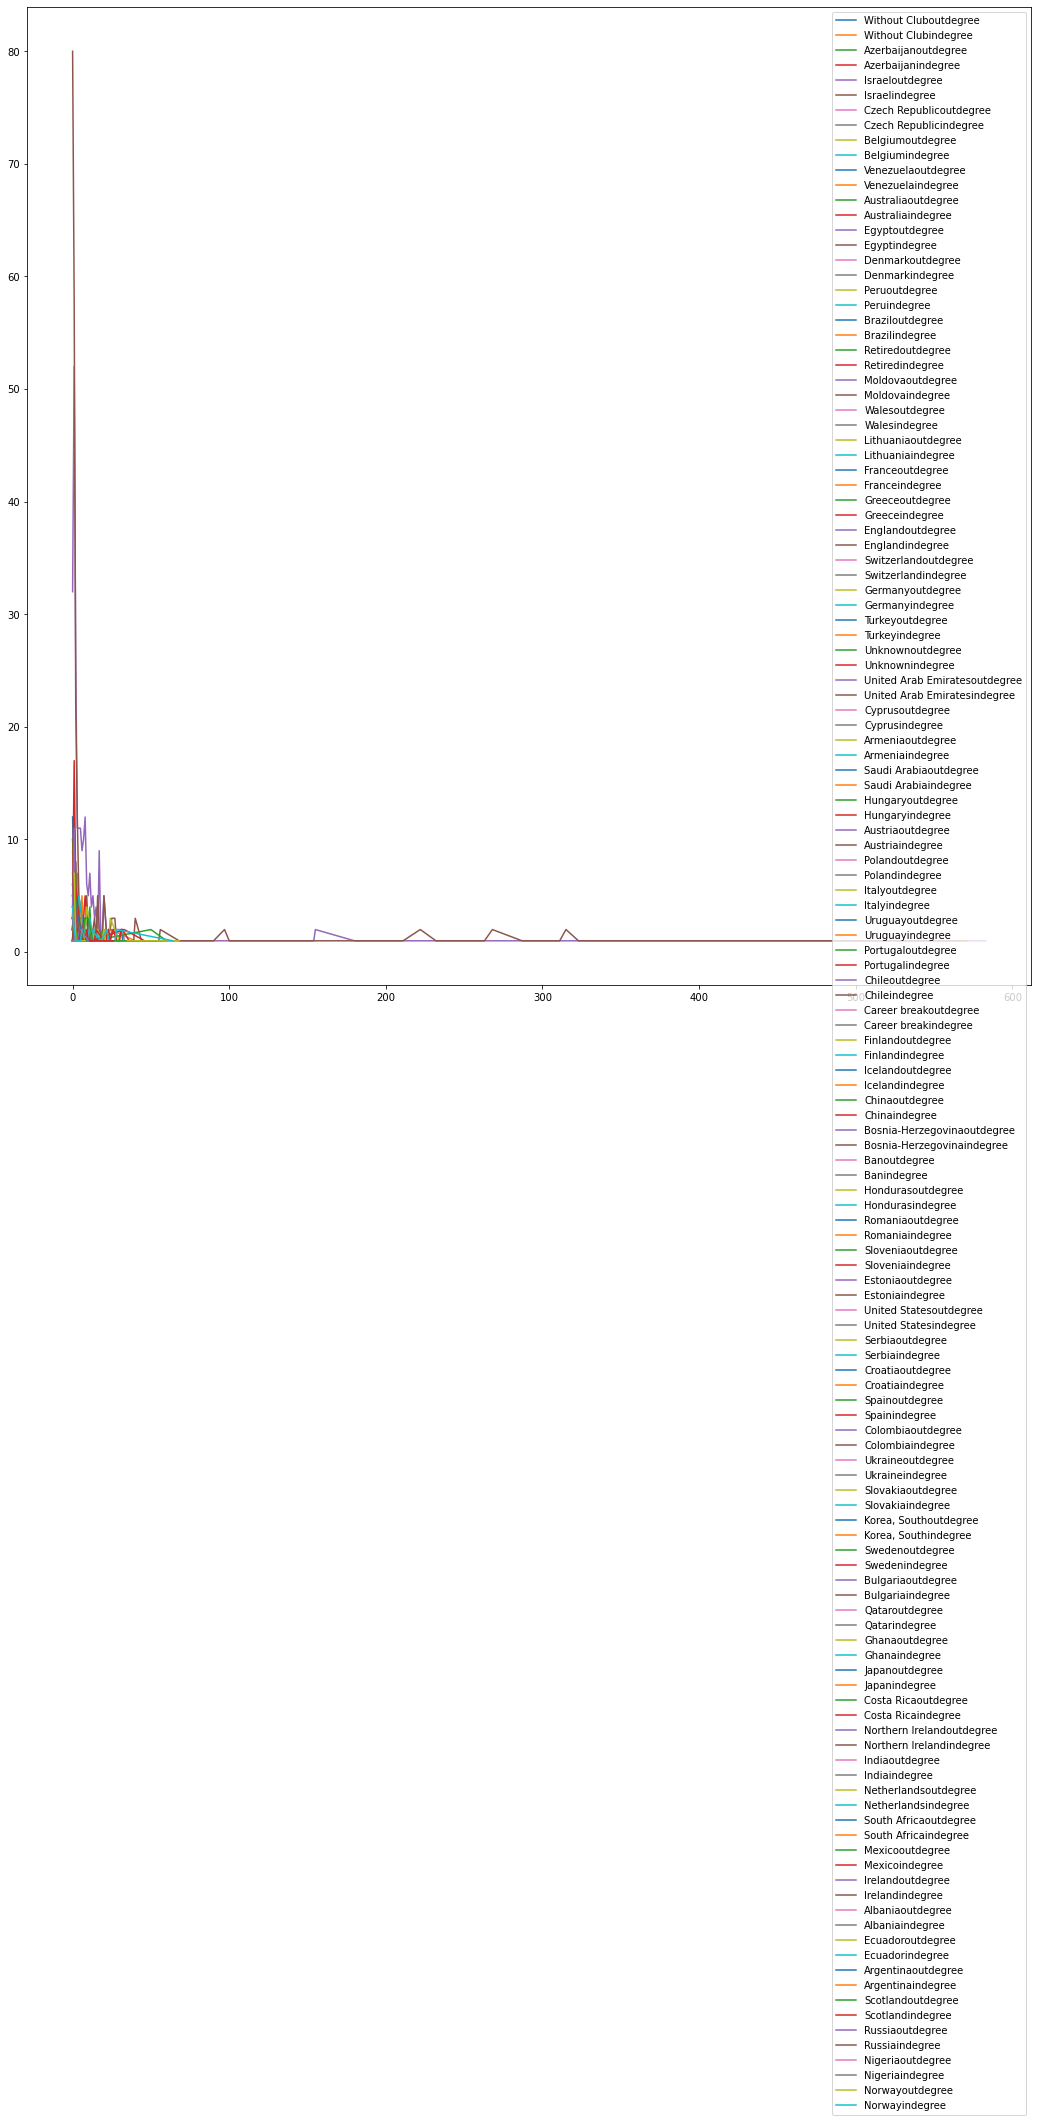

In [10]:
#nx.get_node_attributes(G, 'league')
fig = plt.figure("Degree of a random graph", figsize=(18, 18))
for i in tmpset:
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    outdegree_sequence = sorted((d for n, d in G.out_degree() if n in tmpnodes), reverse=True)
    indegree_sequence = sorted((d for n, d in G.in_degree() if n in tmpnodes), reverse=True)
    plt.plot(*np.unique(outdegree_sequence, return_counts=True), label=i+'outdegree')
    plt.plot(*np.unique(indegree_sequence, return_counts=True), label=i+'indegree')
plt.legend()
plt.show()

In [11]:
transferstocountry = dict()
transfersfromcountry = dict()
for i in tmpset:
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    outdegree_sequence = sorted((d for n, d in G.out_degree() if n in tmpnodes), reverse=True)
    transfersfromcountry[i] = sum(outdegree_sequence)
    indegree_sequence = sorted((d for n, d in G.in_degree() if n in tmpnodes), reverse=True)
    transferstocountry[i] = sum(indegree_sequence)

In [12]:
sorted_ttc = sorted(transferstocountry.items(), key=lambda x:x[1], reverse=True)
sorted_tfc = sorted(transfersfromcountry.items(), key=lambda x:x[1], reverse=True)
print('transfers to country')
print(sorted_ttc[1:11])
print('transfers from country')
print(sorted_tfc[1:11])

transfers to country
[('Spain', 632), ('Italy', 415), ('France', 382), ('Netherlands', 365), ('Germany', 357), ('Without Club', 258), ('Portugal', 208), ('Scotland', 163), ('Retired', 103), ('Turkey', 101)]
transfers from country
[('Spain', 650), ('France', 521), ('Italy', 494), ('Netherlands', 423), ('Germany', 410), ('Portugal', 249), ('Scotland', 161), ('Belgium', 91), ('Turkey', 60), ('Without Club', 57)]


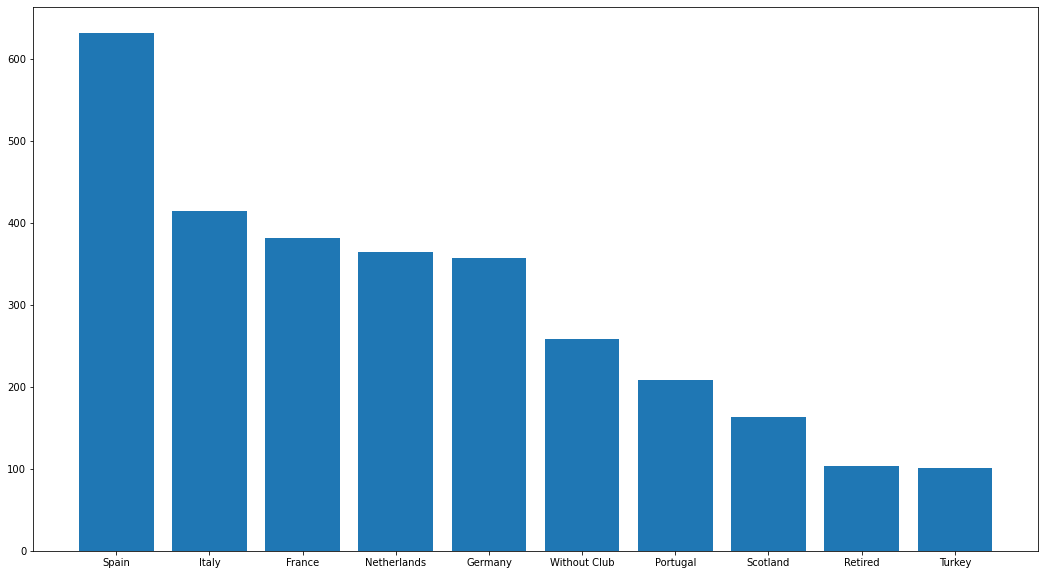

In [13]:
x = []
y = []
for i in sorted_ttc[1:11]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries buying players from the premier league", figsize=(18, 10))
plt.bar(x,y)
plt.show()

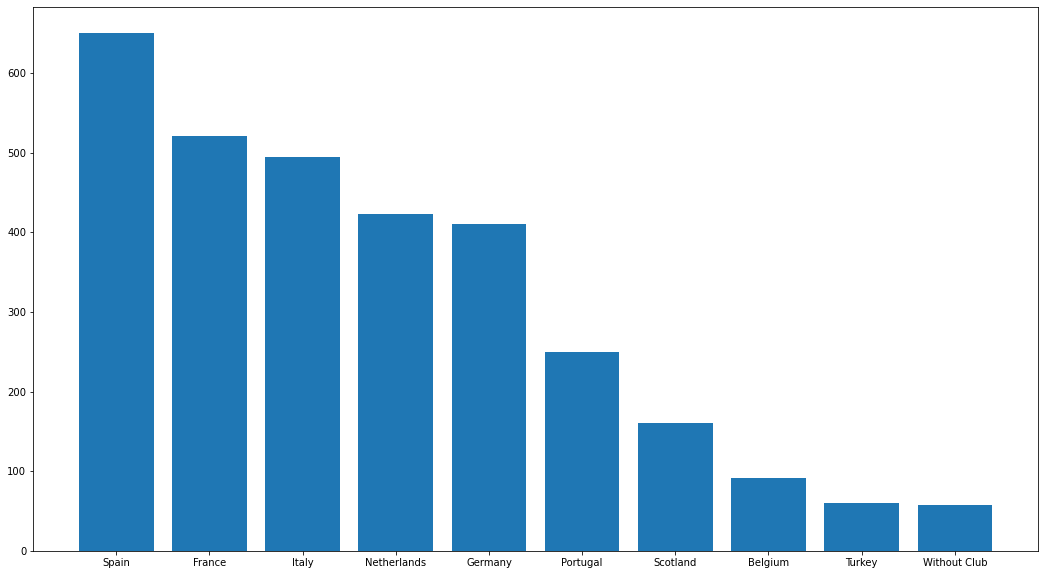

In [14]:
x = []
y = []
for i in sorted_tfc[1:11]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries selling players to the premier league", figsize=(18, 10))
plt.bar(x,y)
plt.show()

In [15]:
nx.get_edge_attributes(G, 'fee')
transferfeetocountry = dict()
transferfeefromcountry = dict()
for i in tmpset:
    if i == 'England':
        continue
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    tmpfrom = [z['fee'] for f, t, z in G.edges(data=True) if f in tmpnodes]
    transferfeefromcountry[i] = sum(tmpfrom)
    tmpto = [z['fee'] for f, t, z in G.edges(data=True) if t in tmpnodes]
    transferfeetocountry[i] = sum(tmpto)

In [16]:
counter = 0
for x,y,z in G.edges(data=True):
    counter+=1

In [17]:
sorted_tftc = sorted(transferfeetocountry.items(), key=lambda x:x[1], reverse=True)
sorted_tffc = sorted(transferfeefromcountry.items(), key=lambda x:x[1], reverse=True)
print('transfers to country')
print(sorted_tftc[1:11])
print('transfers from country')
print(sorted_tffc[1:11])

transfers to country
[('Italy', 1283522000.0), ('Germany', 921640000.0), ('France', 815130000.0), ('China', 193890000.0), ('Netherlands', 149740000.0), ('Russia', 128700000.0), ('Turkey', 117121000.0), ('Portugal', 105580000.0), ('Qatar', 36000000.0), ('Scotland', 35640000.0)]
transfers from country
[('France', 3712295000.0), ('Germany', 2896300000.0), ('Italy', 2804400000.0), ('Portugal', 1619828000.0), ('Netherlands', 1285775000.0), ('Belgium', 337510000.0), ('Russia', 205690000.0), ('Brazil', 195380000.0), ('Scotland', 171280000.0), ('Ukraine', 127715000.0)]


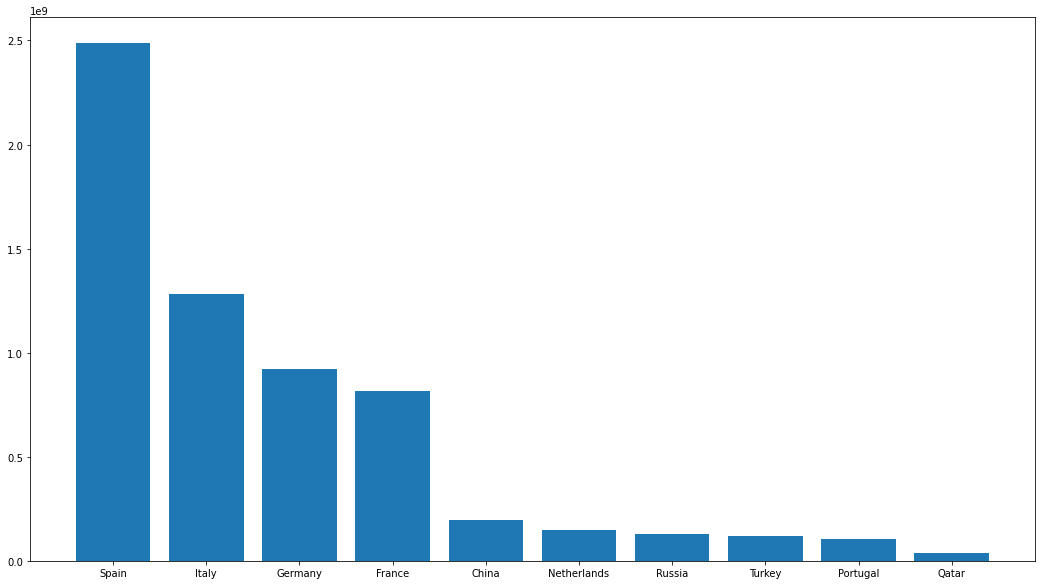

In [18]:
x = []
y = []
for i in sorted_tftc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries buying players from the premier league, fee", figsize=(18, 10))
plt.bar(x,y)
plt.show()

In [19]:
print(transferfeefromcountry['Spain'])
print(transferfeefromcountry['Italy'])

4170615000.0
2804400000.0


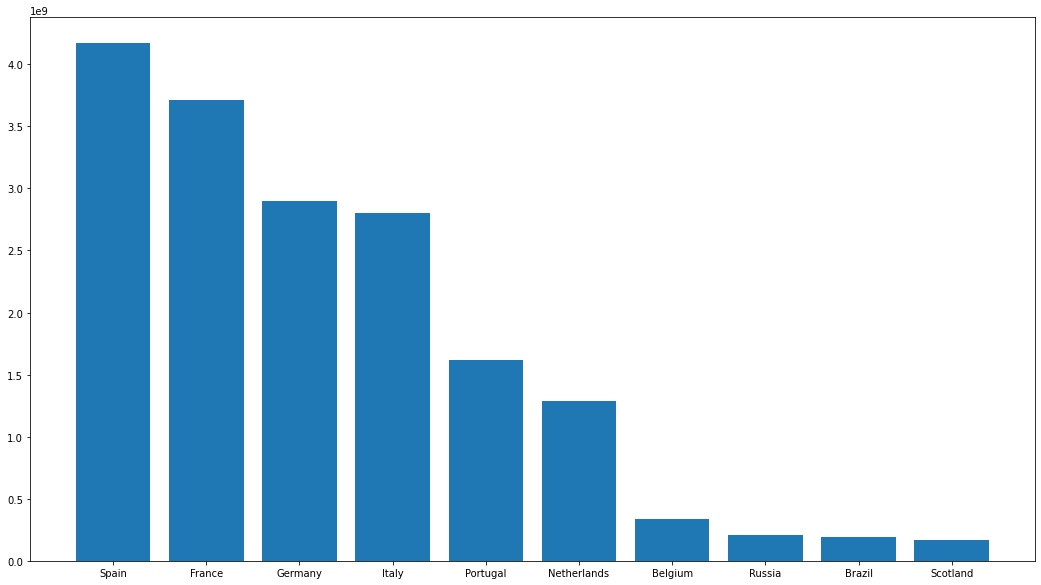

In [20]:
x = []
y = []
for i in sorted_tffc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries selling players to the premier league, fee", figsize=(18, 10))
plt.bar(x,y)
plt.show()